<h1 align="center">UW CNC Fall Hackathon </h1>  
<h3 align="center"> Dec 4, 2024 </h3>   
<h3 align="center"> mapping mesoscale connectivity between the frontal cortex and thalamus</h3> 
    
    

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Overview:** In this notebook, we will analyze thalamic projections to frontal cortex using a 3D light sheet microscopy dataset from whole mouse brains. While this tutorial focuses on thalamocortical connectivity, the dataset contains connections between the frontal cortex and other brain regions, which have yet to be thoroughly explored. 
    
**Dataset:**  This dataset was collected using the mesoscale anatomy platform established at the Allen Institute for Neural Dynamics. Brain samples are cleared and imaged on a SmartSPIM lightsheet microscope. Images are stitched and fused into a 3D volume and aligned to the Common Coordinate Framework (CCF), which allows for integration between samples. Candidate cell somas are algorithmically detected and then classified as true detections or non-cells using a trained deep neural network. This yields a collection of cells throughout the brain, each of which are localized within CCF space. The datasets in this tutorial have been QC'd to verify accurate cell detection, but this verification has been primarily performed in thalamus. Care should be taken to verify cell counts in other regions before drawing strong conclusions. 
    
**Experiment:** These experiments are focused on the structure of inputs to frontal cortex. Retrograde viruses were injected across the frontal cortex, eliciting expression of nuclear-localized fluorophores in infected cells. These injections label somas at the site of virus delivery, as well as the somas of neurons with axonal projections to that location. The brains in this dataset received 1-3 injections of viruses expressing spectrally distinct fluorophores, and thus each injection is conceptualized as an independent connectivity mapping experiment. While the majority of these viral injections employed AAVrg-XFPs, other reagents were also used to address potential cellular or axonal density based tropism. The location of each injection site was empirically determined.
        
    
**Goal:** This tutorial will show you how to:  
    1. analyze connectivity across brain regions  
    2. work with 3D volumetric microscopy data of whole mouse brains 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #1fa970; ">
MTS: Note for Mathew to remember to include flatmap visualization of injections.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Import packages and load data<br>
    
    

In [1]:
# general imports 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, ListedColormap
from IPython.core.display import HTML

import pandas as pd
%matplotlib inline

In [2]:
# specific imports and brain atlas initialization 

from load_data import load_data
import brainglobe_atlasapi as atlasapi
from brainglobe_atlasapi import BrainGlobeAtlas
atlasapi.config.write_config_value('brainglobe_dir', '/data/.brainglobe') # points to allen mouse atlases pre-loaded in data folder 
atlas = BrainGlobeAtlas('allen_mouse_25um', 
                        check_latest = False) # load CCF mouse brain atlas, 25um resolution 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Load metadata

Looking at the injection sites in the metadata dataframe, we see that the injection sites are spatially similar across the imaged channels. We can compare the variability in expression across the channels in a single brain dataset in which the same virus is expressed but with different titers. 
    

In [3]:
metadata_df = pd.read_csv('/scratch/metadata.csv')

metadata_df

,Unnamed: 0,name,subject_id,genotype,sex,virus,titer,ap,ml,dv,volume,age_days,days_to_perfusion,qc_tissue_quality,qc_channel,ng_link,channel
0,0,SmartSPIM_678704_2023-06-20_20-49-52_stitched_...,678704,wt/wt,Male,AAVrg-Syn-H2B-Turquoise,4.800000e+13,2.8,1.8,1.0,50.0,45,28,Fail,Fail,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445
1,1,SmartSPIM_678704_2023-06-20_20-49-52_stitched_...,678704,wt/wt,Male,AAVrg-Syn-H2B-tdTomato,5.100000e+13,2.4,1.8,0.8,50.0,45,28,Fail,Pending,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561
2,2,SmartSPIM_678703_2023-06-20_17-18-27_stitched_...,678703,wt/wt,Male,AAVrg-Syn-H2B-Turquoise,4.800000e+13,1.6,0.2,2.0,50.0,45,28,Fail,Pending,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445
3,3,SmartSPIM_678703_2023-06-20_17-18-27_stitched_...,678703,wt/wt,Male,AAVrg-Syn-H2B-tdTomato,5.100000e+13,2.0,0.6,0.6,50.0,45,28,Fail,Pending,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561
4,4,SmartSPIM_678706_2023-06-28_16-43-04_stitched_...,678706,wt/wt,Female,AAVrg-Syn-H2B-Turquoise,4.800000e+13,2.8,1.0,1.2,50.0,45,28,Fail,Fail,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,156,SmartSPIM_674182_2023-06-22_13-24-46_stitched_...,674182,wt/wt,Male,AAVrg-Syn-H2B-Turquoise,4.800000e+13,2.4,0.6,1.0,50.0,52,28,Fail,Fail,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445
157,157,SmartSPIM_674182_2023-06-22_13-24-46_stitched_...,674182,wt/wt,Male,AAVrg-Syn-H2B-tdTomato,5.100000e+13,2.4,1.0,1.0,50.0,52,28,Fail,Pending,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561
158,158,SmartSPIM_693196_2023-09-28_23-12-22_stitched_...,693196,wt/wt,Female,AAVrg-Syn-H2B-Turquoise,2.960000e+14,2.0,1.0,0.6,50.0,52,28,Pass,Fail,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445
159,159,SmartSPIM_693196_2023-09-28_23-12-22_stitched_...,693196,wt/wt,Female,AAVrg-Syn-H2B-tdTomato,5.100000e+13,2.4,1.4,1.0,50.0,52,28,Pass,Fail,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
Let's search the metadata_df for a subject_id that has these criteria:   
    
1) wildtype (wt/wt) genotype  
2) multiple AAV viral injections at similar injection sites but different titers   
3) passes tissue and channel QC
   

In [4]:
filtered_metadata_df = metadata_df[(metadata_df.genotype == 'wt/wt') & 
           (metadata_df.virus.str.contains('AAV')) & 
           (metadata_df.qc_tissue_quality == 'Pass') & 
           (metadata_df.qc_channel == 'Pass')]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Load data for a single brain 
      
The load_data object class is a wrapper for pulling relevant lightsheet data and data products from the /data folders for a given mouse ID.  

Here, you can see which channels went through each stage of processing.  
(raw image channels > cell detection model applied > transformation to CCF space). * Note that 639 is used for imaging autofluorescence and should not have detected cells. 


In [ ]:
help(load_data)

In [5]:
mouse_ID = '689238' 
x = load_data(mouse_ID)

Loading data from ../data/SmartSPIM_689238_2023-08-31_01-56-52_stitched_2023-09-12_07-47-44/image_tile_fusing/OMEZarr
Found the following channels: ['445', '488', '561', '639']
Found cell segmentations in the following channels: ['445', '488', '561']
Found CCF aligned quantifications in the following channels: ['445', '488', '561']
Grabbing volumes for level: 3


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

we'll save the list of channels with cell segmentations that are aligned to ccf for future reference later on. 

In [6]:
channels = list(x.quantPaths.keys())
channels

['445', '488', '561']

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can look at the imaging data using neuroglancer, a webGL based tool for visualizing and exploring large volumetric anatomy datasets. Each imaged channel has a neuroglancer link embedded in the metadata dataframe. 

In [7]:
links = metadata_df.loc[metadata_df.subject_id == int(mouse_ID), 'ng_link']

# render multiple clickable links 
HTML(' '.join([f'<a href="{link}" target="_blank">{link}</a><br><br>' for link in links]))


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Automated Cell Detection**  
    
With this dataset, we can map which brain regions provide input to the frontal cortex. To do so, we need to find all of the cells labelled by each viral injection, and the locations of those cells in the brain. Manually annotating these cells is quite laborious, especially at the whole brain scale. To facilitate quantitative insights from these experiments, cells were automatically detected using machine vision models. The rest of this tutorial will show you how to load and analyze the spatial coordinates of these detected cells. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The `getCellsCCFdf` function loads the spatial coordinates of the detected cells in a given channel. Note that these coordinates are transformed into CCF space. 

In [ ]:
help(x.getCellsCCFdf)

In [8]:
cellLocs = x.getCellsCCFdf(channels)
cellLocs

,AP,DV,ML,channel
0,220,24,266,445
1,221,25,272,445
2,221,25,277,445
3,218,25,269,445
4,218,27,260,445
...,...,...,...,...
447373,322,280,342,561
447374,312,282,346,561
447375,305,280,348,561
447376,296,280,354,561


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

**Task 1:** How many cells were detected in each channel? 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's look at the expression patterns across each channel. Since this project is focused on mapping thalamocortical connections, we'll take a slice of the brain centered around the thalamus and plot a histogram of the spatial coordinates of the cells targeted in that region. We'll plot in the coronal plane. Using the atlas.get_structure_mask function, we can also overlay the brain structure boundaries to help us identify where the cell targets are. 
    
You can play around with the `plane` and `window` parameters to adjust the location and thickness of the slice we plot or the roiList to outline different brain regions. 

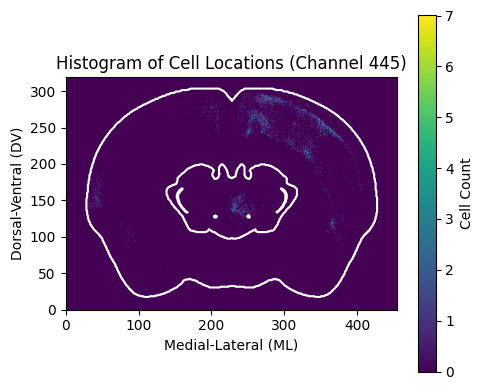

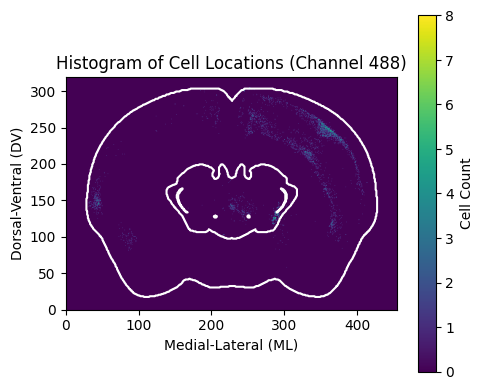

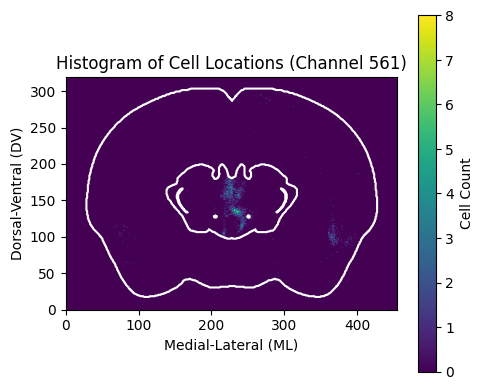

In [9]:
plane = 250 
window = 5
roiList = ["root", "TH"]

# Loop through each channel 
for ch in channels: 
    
    # Set figure parameters 
    fig, ax = plt.subplots(figsize=(5, 4))

    # Generate contour outlines for brain structures
    for roi in roiList:
        roi_mask = atlas.get_structure_mask(roi)
        ax.contour(
            roi_mask[plane, :, :],
            levels=[0.5],
            colors="white",
            linewidths=1.5,
            origin="upper"
        )

    # Generate the histogram of cell coordinates
    planeLocs = cellLocs.loc[
        (cellLocs['AP'] >= plane - window) & (cellLocs['AP'] <= plane + window), :
    ]

    xbins = np.arange(0, atlas.get_structure_mask("root").shape[2], 1)
    ybins = np.arange(0, atlas.get_structure_mask("root").shape[1], 1)
    hist, xedges, yedges = np.histogram2d(
        planeLocs[planeLocs['channel'] == ch]["ML"],
        planeLocs[planeLocs['channel'] == ch]["DV"],
        bins=(xbins, ybins),
    )

    # Overlay the heatmap
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    heatmap = ax.imshow(
        hist.T,  # Transpose because imshow expects (rows, cols)
        extent=extent,
        origin="upper",
        cmap="viridis",
        alpha=1,
    )

    # Add colorbar and labels
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label("Cell Count")
    ax.set_title(f"Histogram of Cell Locations (Channel {ch})")
    ax.set_xlabel("Medial-Lateral (ML)")
    ax.set_ylabel("Dorsal-Ventral (DV)")

    plt.tight_layout()
    plt.show()


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
Focusing on the thalamus, it appears that each channel has labelling in different subregions of the thalamus.  
    
To quantify the differences in expression across the thalamic subregions with different viral titers, we can compare the differences in cell counts across each thalamic brain structure. We will use the `getcellcounts` function to load a dataframe of the cell counts in each brain structure. 

    

| Column    | Description |
| -------- | ------- |
| ID  | number id of brain structure   |
| Acronym | shorthand name of brain structure     |
| Name | full name of brain structure     |
| Struct_Info    | mid = symmetric across left/right hemisphere, hemi = not symmetric   |
| Struct_area_um3   | volume of brain structure    |
| Left    | left hemisphere cell counts    |
| Right    | right hemisphere cell counts   |
| Total    | total cell counts   |
| Left_Density    | density of cells in left hemisphere of brain structure  |
| Right_Density    | density of cells in right hemisphere of brain structure  |
| Total_Density    | density of cells in total brain structure   |
| channel    | channel name    |

In [ ]:
help(x.getcellcounts)

In [10]:
cell_counts_df = x.getcellcounts(channels) # for each channel, there's a row for each structure in the CCF ontology 
cell_counts_df 

,ID,Acronym,Name,Struct_Info,Struct_area_um3,Left,Right,Total,Left_Density,Right_Density,Total_Density,channel
0,997,root,root,mid,5.113271e+11,21025,151133,172158,8.223698e-08,5.911401e-07,3.366886e-07,445
1,8,grey,Basic cell groups and regions,hemi,2.312776e+11,20967,144024,164991,9.065730e-08,6.227322e-07,3.566948e-07,445
2,567,CH,Cerebrum,hemi,1.414069e+11,20477,138187,158664,1.448090e-07,9.772295e-07,5.610193e-07,445
3,688,CTX,Cerebral cortex,hemi,1.137573e+11,20424,131707,152131,1.795401e-07,1.157789e-06,6.686647e-07,445
4,695,CTXpl,Cortical plate,hemi,1.093212e+11,20320,129944,150264,1.858743e-07,1.188644e-06,6.872593e-07,445
...,...,...,...,...,...,...,...,...,...,...,...,...
2509,129,V3,third ventricle,mid,1.139386e+09,60,81,141,1.053199e-07,1.421819e-07,1.237509e-07,561
2510,140,AQ,cerebral aqueduct,mid,4.506497e+08,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,561
2511,145,V4,fourth ventricle,mid,1.372785e+09,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,561
2512,153,V4r,lateral recess,hemi,3.813698e+08,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,561


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

To help us assess the connectivity across brain regions, we can use cell_counts_df to construct a connectivity matrix. First, let's filter our dataframe to cells within thalamic subregions. Then, we will use pivot_table to create a connectivity matrix where each row is a channel, each column is a brain region, and the values are cell counts. 

In [12]:
# thalamic subregions of interest 
roiList = ["MD", "PT", "IAD", "PVT", "IMD", "CM", "PCN", "CL"]

# filter the df for cells within the roiList 
filtered_cell_counts_df = cell_counts_df[cell_counts_df["Acronym"].isin(roiList)] 

# generate connectivity matrix: 
# rows = channels 
# columns = thalamus brain regions 
# values = cell counts 

conn_mat = filtered_cell_counts_df.pivot_table(index = "channel", 
                                      columns = "Acronym", 
                                      values = "Total")
conn_mat

Acronym,CL,CM,IAD,IMD,MD,PCN,PT,PVT
channel,,,,,,,,
445,3,1104,19,80,1987,149,12,387
488,20,1302,8,95,2149,150,7,330
561,0,313,53,98,760,2,473,1910


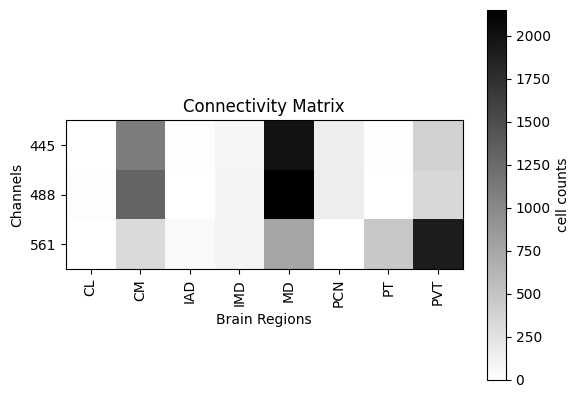

In [13]:
# plot the connectivity matrix as a heatmap 

plt.imshow(conn_mat, cmap="gray_r")
plt.colorbar(label="cell counts")
plt.xticks(ticks=range(len(conn_mat.columns)), labels=conn_mat.columns, rotation=90)
plt.yticks(ticks=range(len(conn_mat.index)), labels=conn_mat.index)
plt.title("Connectivity Matrix")
plt.xlabel("Brain Regions")
plt.ylabel("Channels")
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

**Task 2:** Since each brain structure is variable in size, the total density might be more informative than the total cell counts. Try reconstructing the connectivity matrix and gridded heatmap using total density.  
**Bonus:** plot as an anatomical heatmap where each brain structure is shaded accordingly with the total density 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

**Load multiple datasets**  
    
The following code gives an example of batch processing multiple datasets. This will iterate through a list of IDs and output a dataframe of cell locations for each spatial coordinate and cell counts per brain region. Additionally, we have added a function to attach new columns with information referenced from the metadata dataframe. 

In [81]:
def batch_process(id_list): 
    """
    Loads data for a list of subject_ids. 
    
    Parameters:
        id_list: List of subject_ids 

    Returns:
        cell_locations_df: pandas.DataFrame of cell locations with an additional subject_id column 
        cell_counts_df: pandas.DataFrame of cell counts in each brain structure with an additional subject_id column 
    """
    all_cell_locations = [] 
    all_cell_counts = [] 

    for mouse_ID in id_list: 
        x = load_data(mouse_ID)
        channels = list(x.quantPaths.keys())

        if len(channels) > 0: 
            cell_locations = x.getCellsCCFdf(channels)
            cell_locations = cell_locations.assign(subject_id = mouse_ID) 
            all_cell_locations.append(cell_locations) 

            cell_counts = x.getcellcounts(channels)
            cell_counts = cell_counts.assign(subject_id = mouse_ID)
            all_cell_counts.append(cell_counts) 

        else: 
            pass 

    cell_locations_df = pd.concat(all_cell_locations)
    cell_counts_df = pd.concat(all_cell_counts)
    
    return cell_locations_df, cell_counts_df 


def add_metadata_info(data_df, metadata_df, key_columns, additional_columns):
    """
    Cross-references a data_df with metadata_df based on key columns (subject_id and channel) and adds additional columns from metadata_df. 
    
    Parameters:
        data_df: DataFrame containing the data to add metadata information to. 
        metadata_df: DataFrame containing metadata information. 
        key_columns: list of str, list of column names to use as keys for matching (e.g. ['subject_id', 'channel']
        additional_columns: list of str, list of column names from metadata_df to add to data_df. 
        
    Returns:
        merged_df: Updated DataFrame with original data_df and merged columns from metadata_df 

    """
    # Converts data within key columns to str 
    for key in key_columns:
        data_df[key] = data_df[key].astype(str)  # Convert to string
        metadata_df[key] = metadata_df[key].astype(str)  # Convert to string

    # Filter metadata_df based on key_columns to match and additional_columns 
    metadata_subset = metadata_df[key_columns + additional_columns]
    
    # Merge data_df and metadata_df based on key columns 
    merged_df = data_df.merge(metadata_subset, on=key_columns, how='left')
    
    return merged_df



In [82]:
# iterate through list of subject_ids and generate dataframe of cell locations and cell counts 
# this takes a while to load, so only going through a few ids 
[cell_locations_df, cell_counts_df] = batch_process(filtered_metadata_df.subject_id.unique().tolist()[0:2])

# attach new columns with metadata information 

# Define key columns for matching
key_columns = ['subject_id', 'channel']

# Define additional columns to add
additional_columns = ['virus', 'titer']

# Add metadata to cell locations DataFrame
cell_locations_with_metadata = add_metadata_info(cell_locations_df, metadata_df, key_columns, additional_columns)

# Add metadata to cell counts DataFrame
cell_counts_with_metadata = add_metadata_info(cell_counts_df, metadata_df, key_columns, additional_columns)


Loading data from ../data/SmartSPIM_689237_2023-08-30_19-04-37_stitched_2023-09-12_08-06-57/image_tile_fusing/OMEZarr
Found the following channels: ['445', '488', '561', '639']
Found cell segmentations in the following channels: ['445', '488', '561']
Found CCF aligned quantifications in the following channels: ['445', '488', '561']
Grabbing volumes for level: 3
Loading data from ../data/SmartSPIM_689238_2023-08-31_01-56-52_stitched_2023-09-12_07-47-44/image_tile_fusing/OMEZarr
Found the following channels: ['445', '488', '561', '639']
Found cell segmentations in the following channels: ['445', '488', '561']
Found CCF aligned quantifications in the following channels: ['445', '488', '561']
Grabbing volumes for level: 3


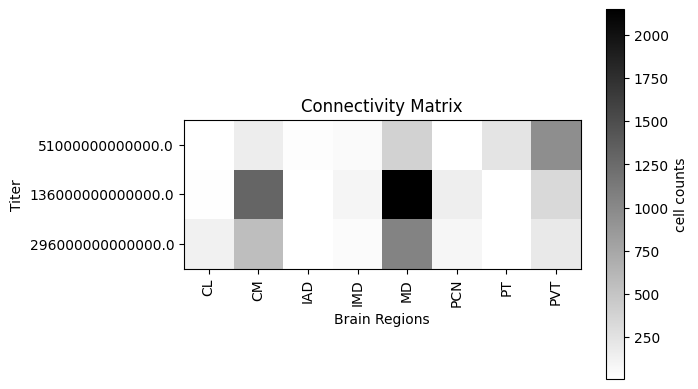

In [88]:
# thalamic subregions of interest 
roiList = ["MD", "PT", "IAD", "PVT", "IMD", "CM", "PCN", "CL"]

# filter the df for cells within the roiList 
filtered_cell_counts_df = cell_counts_with_metadata[cell_counts_with_metadata["Acronym"].isin(roiList)] 

# generate connectivity matrix: 
# rows = channels 
# columns = thalamus brain regions 
# values = cell counts 

conn_mat = filtered_cell_counts_df.pivot_table(index = "titer", 
                                      columns = "Acronym", 
                                      values = "Total")

plt.imshow(conn_mat, cmap="gray_r")
plt.colorbar(label="cell counts")
plt.xticks(ticks=range(len(conn_mat.columns)), labels=conn_mat.columns, rotation=90)
plt.yticks(ticks=range(len(conn_mat.index)), labels=conn_mat.index)
plt.title("Connectivity Matrix")
plt.xlabel("Brain Regions")
plt.ylabel("Titer")
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
 
Questions to explore further: 

* Can you predict x metadata from y measurement? (e.g. predict injection coordinates from labelled structures) 

* Does the virus identity matter? Assess the variability in targeted expression across injection sites. 

* Is there spatial topography in the labelling? 

* Explore expression patterns beyond the thalamus. Some starting points: amygdala, other cortial areas, locus coeruleus. 
    
* Apply data-driven parcellations to the spatial coordinates of detected cells such as NMF 


